# Natural Language Processing- CNN Model Final Project
#### Javier Rodriguez, Edgar Leon
#### Section ??

## Introduction
Exploration of tokenizing embeddings using a pretrained fasttext twitter embedding. We will use it to train a neural network.
## FastText:

The “fasttext_english_twitter_100d.vec” file is a set of word vectors trained using the FastText library.

FastText is a library developed by Facebook’s AI Research (FAIR) lab. It’s dedicated to text classification and learning word representations. FastText models can be trained on more than a billion words on any multicore CPU in less than a few minutes.

Here’s a general process of how FastText trains word vectors:

Corpus Selection: FastText trains word vectors on large text corpora. For example, FastText provides pre-trained word vectors trained, in this case, a collection of English tweets.
Model Training: These models are trained using the Continuous Bag of Words (CBOW) model with position-weights, in a specified dimension (like 300), with character n-grams of length 5, a window of size 5, and 10 negatives2.
Vector Generation: Each line of the output file contains a word followed by its vectors, like in the default FastText text format. Each value is space-separated. Words are ordered by descending frequency.


FastText vectors do have embedded meaning. Words that have similar meanings tend to have similar vector representations, meaning they occupy close spaces in the vector space.

This property is a result of the way FastText trains its models. During training, FastText uses the context of each word — the words that come before and after it in the text. Words that appear in similar contexts tend to have similar meanings. Therefore, the model learns to represent similar words with similar vectors.

This feature of word embeddings is very useful in many natural language processing tasks. For example, it allows us to measure the semantic similarity between words or sentences, perform analogical reasoning (like “man” is to “woman” as “king” is to “queen”), and even improve the performance of text classification models by leveraging the semantic information captured in the word vectors.



In [ ]:
!pip install altair==5.2.0 --quiet #collab default is 4.2.2<-not working

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.9/996.9 kB 12.9 MB/s eta 0:00:00


In [ ]:
import altair as alt
print(alt.__version__)

5.2.0


In [ ]:
!pip install gensim #needed to import fast text twitter embeddings


In [ ]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay, accuracy_score


import os
import pathlib

import math
import plotly.graph_objs as plotly  # for interactive plots

## For GridSearch
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC  # Replace with the model you want to use for grid search
#import altair as alt #to make nice plots
import re
#do need
from tqdm import tqdm
import time
from gensim.models import KeyedVectors

In [ ]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Navigate to the Directory Containing the CSV File
import os
os.chdir('/content/drive/My Drive/DS266 Project')


Get Data

In [ ]:
# Read the CSV File
import pandas as pd
tweets_df = pd.read_csv('train.csv')

In [ ]:
tweets_df.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


## Import Twitter Based Embeddings
#### Source:

For this project, we chose to start the project off with a pre-trained word embeddings in twitter. The pre-trained word embeddings we used was GloVe, which was trained on global word-word co-occurance statistics from a large text data set. It contains 400,000 words of 50 dimensional vectors.

In [ ]:
# Load vectors directly from the file
vector_model = KeyedVectors.load_word2vec_format('fasttext_english_twitter_100d.vec')




### Some Sanity Check Tests

After downloading Fast Text Tweet Embeddings we did a quick sanity check to see if some of the words we anticipate to commonly show up in our tweets text are captured.

In [ ]:

def check_word(item_value, model):
  word = None
  #print(model[item_value])
  #print(item_value)
  try:
    if model[item_value].any():
      word = "\""+item_value +"\" exists in embeddings dictionary"
      vector = model[item_value]
  except:
    word = "\""+item_value +"\" does not exist"
    vector = np.zeros((100,))
  return word, vector



In [ ]:
check = ['fire', 'hurricane', 'earthquake', 'sunami', 'disaster']
for i in range(len(check)-0):
  word, vector = check_word(check[i], vector_model)
  print(word)
  print(vector.shape)

"fire" exists in embeddings dictionary
(100,)
"hurricane" exists in embeddings dictionary
(100,)
"earthquake" exists in embeddings dictionary
(100,)
"sunami" does not exist
(100,)
"disaster" exists in embeddings dictionary
(100,)


Since 'sunami' does not exist, then we have to train our embeddings on our data.

## Inputing in Tweets Data Source

The kaggle competition provided us with training and testing data sets in the form of a csv file. The training csv files comes with five columns of data. The first colum is id. The keyword column contains a keyword associated with the tweet text. The location field is populated if the user tagged to it. One caveat to the data is that the keywords and location fields might not always be populated. the text field containst the original tweet. The final column is a 0 or 1 label value. If a tweet is classified as indicating a true emergency then the label is 1 otherwise its 0.

### Initial Data Exploratory Analysis

Our firs step was to conduct initial exploratory analysis. We checked the head or tails of the dataset to make sure the data formatting stays consistent.

In [ ]:
# import csv
#user_results_df.loc[user_results_df["category"] == "I", "pad_radius"] = user_results_df.iloc[1]['score']
tweets_df = pd.read_csv('train.csv')
tweets_df.loc[tweets_df["keyword"].isnull(), "keyword" ] = ''
tweets_df.loc[tweets_df["location"].isnull(), "location" ] = ''
size = tweets_df.shape
tweets_df[100:105].head(5)

,id,keyword,location,text,target
100,144,accident,UK,.@NorwayMFA #Bahrain police had previously die...,1
101,145,accident,"Nairobi, Kenya",I still have not heard Church Leaders of Kenya...,0
102,146,aftershock,Instagram - @heyimginog,@afterShock_DeLo scuf ps live and the game... cya,0
103,149,aftershock,304,'The man who can drive himself further once th...,0
104,151,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/yN...,0


In [ ]:
#creating training data from trainging data set
x_tweets = tweets_df.iloc[0:tweets_df.shape[0], 3:4]
#x_tweets = x_tweets.to_numpy()

y_tweets = tweets_df.iloc[0:tweets_df.shape[0], 4:5]
#y_tweets = y_tweets.to_numpy()

#adding location
#x_loc = tweets_df.iloc[0:tweets_df.shape[0], 2:3].to_numpy()
x_loc = tweets_df.iloc[0:tweets_df.shape[0], 2:3]

#adding keyword

#x_kword = tweets_df.iloc[0:tweets_df.shape[0], 1:2].to_numpy()
x_kword = tweets_df.iloc[0:tweets_df.shape[0], 1:2]

In [ ]:
#determining size of 80% of training data

train_size = math.floor(tweets_df.shape[0]*0.80)
print ("Size of the training data subset: ", train_size)
size = tweets_df.shape[0]
print("Total Size of Training Data set: ", size)
val_start = train_size +1
print("Validation size start: ", val_start)
val_end = val_start + math.floor(tweets_df.shape[0]*0.1)
print("Validation size end: ", val_end)
test_start = val_end + 1
print("Test size start: ", test_start)

#creating training data from trainging data set
x_train_tweets = x_tweets[0:train_size]
y_train_tweets = y_tweets[0:train_size]
#x_train_tweets = x_train_tweets.to_numpy()
#y_train_tweets = y_train_tweets.to_numpy()

#creating validation data from training data set.
x_val_tweets = x_tweets[val_start:val_end]
y_val_tweets = y_tweets[val_start:val_end]
#x_val_tweets = x_val_tweets.to_numpy()
#y_val_tweets = y_val_tweets.to_numpy()

#creating test data from training data set.
x_test_tweets =  x_tweets[test_start:size]
y_test_tweets = y_tweets[test_start:size]



Size of the training data subset:  6090
Total Size of Training Data set:  7613
Validation size start:  6091
Validation size end:  6852
Test size start:  6853


'\n# Apply random shufflying to training examples.\nnp.random.seed(0)\nindices = np.arange(x_train_tweets.shape[0])\nshuffled_indices = np.random.permutation(indices)\nx_train_tweets = x_train_tweets[shuffled_indices]\ny_train_tweets = y_train_tweets[shuffled_indices]\n\n# Apply random shufflying to validation data set.\nindices = np.arange(x_val_tweets.shape[0])\nshuffled_indices = np.random.permutation(indices)\nx_val_tweets = x_val_tweets[shuffled_indices]\ny_val_tweets = y_val_tweets[shuffled_indices]\n'

In [ ]:
x_train_tweets.head(3)

,text
0,Our Deeds are the Reason of this #earthquake M...
1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are ...


We will tokenize the words:

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:

# Assuming sentences is your list of sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_tweets['text']) # first creates a dictionary mapping every unique word in your text data to a unique integer.



In [ ]:
sequences = tokenizer.texts_to_sequences(x_train_tweets['text'])


In [ ]:
print("original tweets: ")
for i in range(5):
  print(i,": ",x_train_tweets.text.iloc[i])
print('tokenized tweets: ')
for i in range(5):
  print(i,": ",sequences[i])

original tweets: 
0 :  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1 :  Forest fire near La Ronge Sask. Canada
2 :  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3 :  13,000 people receive #wildfires evacuation orders in California 
4 :  Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
tokenized tweets: 
0 :  [107, 3995, 22, 4, 837, 8, 21, 370, 121, 1449, 3996, 87, 43]
1 :  [157, 38, 221, 790, 5981, 5982, 1450]
2 :  [43, 1623, 1348, 6, 5983, 7, 5984, 22, 124, 5985, 19, 1624, 40, 458, 211, 56, 2080, 7, 660, 1134, 22, 1349]
3 :  [995, 2456, 58, 3997, 1235, 211, 1134, 7, 101]
4 :  [32, 99, 1236, 21, 431, 24, 5986, 1822, 33, 1054, 24, 1235, 5987, 72, 5, 177]


###Covert back to word

In [ ]:
#
tokenized_sentences = []
for sequence in sequences:
    words = [tokenizer.index_word[token] for token in sequence if token in tokenizer.index_word]
    sentence = ' '.join(words)
    tokenized_sentences.append(sentence)

In [ ]:
for i in range(5):
  print(i,": ",tokenized_sentences[i])


0 :  our deeds are the reason of this earthquake may allah forgive us all
1 :  forest fire near la ronge sask canada
2 :  all residents asked to 'shelter in place' are being notified by officers no other evacuation or shelter in place orders are expected
3 :  13 000 people receive wildfires evacuation orders in california
4 :  just got sent this photo from ruby alaska as smoke from wildfires pours into a school


In [ ]:
print(len(sequences)), print(len(tokenized_sentences))

6090
6090


(None, None)

note above that hashtag is removed, punctuation and all letters are lowercased. This is optional and we can revisit.

###Below we create numpy array with vectorized sentences and padding at the end.

In [ ]:
max_sentence_length = 30 #based on EDA maximum word count is 30
vector_dim = 100
num_sentences = len(tokenized_sentences)

# Initialize a 3D numpy array with zeros
vectorized_sentences = np.zeros((num_sentences, max_sentence_length, vector_dim))

for i in range(num_sentences):
    words = tokenized_sentences[i].split()
    for j in range(min(len(words), max_sentence_length)):
        if words[j] in vector_model:
            vectorized_sentences[i, j, :] = vector_model[words[j]]

print(vectorized_sentences.shape)


(6090, 30, 100)


In [ ]:
 print(sequences[0]), print("length: ", len(sequences[0])), vectorized_sentences[0][12], vectorized_sentences[0][13]
#first sentence is 13 words long, therefore pos 13 is only zeroes

[107, 3995, 22, 4, 837, 8, 21, 370, 121, 1449, 3996, 87, 43]
length:  13


(None,
 None,
 array([ 1.56269997e-01, -1.37379998e-02,  3.37740004e-01,  4.04729992e-01,
        -3.63669991e-02,  1.39290005e-01, -2.53720004e-02,  1.15249999e-01,
        -6.00990024e-04,  1.58660002e-02, -3.72310013e-01,  1.97420001e-01,
         1.06729999e-01,  6.35140017e-02,  2.53749996e-01,  6.01379983e-02,
        -4.39310014e-01,  3.49900015e-02, -8.89699981e-02,  1.95270002e-01,
         1.08709998e-01,  3.29919994e-01, -1.33599997e-01, -2.35139996e-01,
         1.23359999e-02,  7.02890009e-02,  3.10620010e-01, -2.25390002e-01,
        -2.82680005e-01,  5.47089987e-02,  6.37089983e-02,  4.31190014e-01,
        -2.17820004e-01, -4.72200006e-01,  1.01599999e-01, -2.01949999e-01,
        -1.59309998e-01, -3.58450003e-02,  3.26220006e-01,  3.22870016e-02,
        -5.22629991e-02,  3.32599998e-01,  6.10530004e-02,  4.29069996e-01,
        -1.98459998e-01, -1.98599994e-01, -1.93599999e-01,  2.66240001e-01,
        -3.78729999e-01,  3.65520000e-01,  1.79470003e-01, -5.34030013e-02

In [ ]:
train_labels = y_train_tweets['target'].to_numpy()

In [ ]:
train_labels = train_labels.reshape(-1, 1)
train_labels[10:20], train_labels.shape

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0]]),
 (6090, 1))

###We will do the same for validation data

In [ ]:
max_sentence_length = 30
# Assuming sentences is your list of sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_val_tweets['text']) # first creates a dictionary mapping every unique word in your text data to a unique integer.
sequences = tokenizer.texts_to_sequences(x_val_tweets['text'])
tokenized_sentences = []
for sequence in sequences:
    words = [tokenizer.index_word[token] for token in sequence if token in tokenizer.index_word]
    sentence = ' '.join(words)
    tokenized_sentences.append(sentence)
#based on EDA maximum word count is 30
vector_dim = 100
num_sentences = len(tokenized_sentences)

# Initialize a 3D numpy array with zeros
vectorized_val_sentences = np.zeros((num_sentences, max_sentence_length, vector_dim))

for i in range(num_sentences):
    words = tokenized_sentences[i].split()
    for j in range(min(len(words), max_sentence_length)):
        if words[j] in vector_model:
            vectorized_val_sentences[i, j, :] = vector_model[words[j]]

print(vectorized_val_sentences.shape)

(761, 30, 100)


In [ ]:
print(x_val_tweets.text.iloc[0]), print(tokenized_sentences[0] ), print("length: ", len(sequences[0])), print(vectorized_val_sentences[0][24]), print(vectorized_val_sentences[0][25])

that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time
that horrible sinking feeling when youûªve been at home on your phone for a while and you realise its been on 3g this whole time
length:  25
[ 0.17481001  0.18260001 -0.10205     0.032857    0.38372999 -0.18967
 -0.02931    -0.12083    -0.39074999  0.39283001  0.055647    0.39855
  0.25323999 -0.043974   -0.023682   -0.011419   -0.56694001 -0.12059
 -0.39037001  0.24762    -0.17174999  0.30842    -0.059906    0.075074
 -0.069148    0.096894    0.16893999 -0.33679    -0.20124    -0.41428
  0.038496   -0.046757    0.092485   -0.07576     0.21709999 -0.0067144
 -0.56766999 -0.11901    -0.00067966 -0.061472   -0.19169     0.26673999
 -0.15460999  0.22778    -0.082511   -0.23901001 -0.17274    -0.29988
 -0.3294      0.081687   -0.082505    0.20894     0.10242     0.31889999
  0.24851     0.06357    -0.081414   -0.21665999 -0.025407    0.37733001
  0.0011419  -0.

(None, None, None, None, None)

In [ ]:
val_labels = y_val_tweets['target'].to_numpy()
val_labels = val_labels.reshape(-1, 1)
val_labels[0:10], val_labels.shape


(array([[1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1]]),
 (761, 1))

shuffle the data sets

In [ ]:
'''
# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(x_train_tweets.shape[0])
shuffled_indices = np.random.permutation(indices)
x_train_tweets = x_train_tweets[shuffled_indices]
y_train_tweets = y_train_tweets[shuffled_indices]

# Apply random shufflying to validation data set.
indices = np.arange(x_val_tweets.shape[0])
shuffled_indices = np.random.permutation(indices)
x_val_tweets = x_val_tweets[shuffled_indices]
y_val_tweets = y_val_tweets[shuffled_indices]
'''


#Lets Start Building the Neural Network Model

plotting tool

In [ ]:
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

build training, validation and test set: need to change the below for a transformer architecture model

In [ ]:
from tensorflow.keras import layers

# Define the shape of your input data
input_shape = (30, 100)  # 30 words per sentence and 100 dimensions per word

# Define your model
inputs = keras.Input(shape=input_shape, dtype="float32")
x = layers.Conv1D(128, 5, activation="relu")(inputs)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.85)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 100)]         0         
                                                                 
 conv1d (Conv1D)             (None, 26, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                             

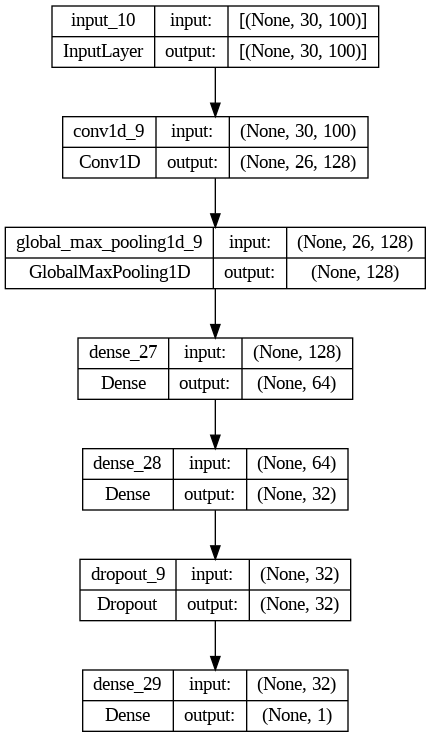

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="model_diagram.png", show_shapes=True, show_layer_names=True)

Epoch 1/10
46/48 [===========================>..] - ETA: 0s - loss: 0.6837 - accuracy: 0.5686

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 2s 21ms/step - loss: 0.6835 - accuracy: 0.5675 - val_loss: 0.6339 - val_accuracy: 0.7332
Epoch 2/10
48/48 [==============================] - 1s 12ms/step - loss: 0.6309 - accuracy: 0.6374 - val_loss: 0.5813 - val_accuracy: 0.7346
Epoch 3/10
48/48 [==============================] - 1s 12ms/step - loss: 0.5861 - accuracy: 0.6844 - val_loss: 0.5057 - val_accuracy: 0.7884
Epoch 4/10
48/48 [==============================] - 1s 13ms/step - loss: 0.5557 - accuracy: 0.7039 - val_loss: 0.5010 - val_accuracy: 0.7714
Epoch 5/10
48/48 [==============================] - 1s 12ms/step - loss: 0.5253 - accuracy: 0.7223 - val_loss: 0.4846 - val_accuracy: 0.7845
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5041 - accuracy: 0.7363 - val_loss: 0.5108 - val_accuracy: 0.7608
Epoch 7/10
48/48 [==============================] - 1s 17ms/step - loss: 0.4885 - accuracy: 0.7448 - val_loss: 0.4598 - val_accuracy: 0.8029
Epoch 8/10
48/48 [======

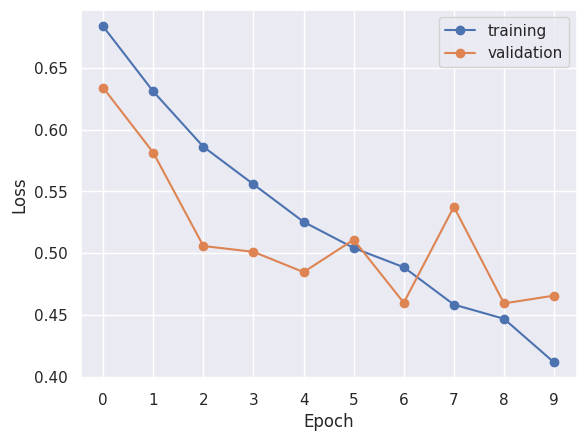

In [ ]:
from keras import losses

checkpoint_dir = './model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'cnn_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'


callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=4,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_loss", #'val_loss'
        save_best_only=True,
    )
]
model.compile(
    loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"]
)
history = model.fit(vectorized_sentences, train_labels, batch_size=128, epochs=10, callbacks=callbacks_list,  \
                    validation_data=(vectorized_val_sentences, val_labels))

# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
plot_history(history)


##Lets have some fun

pick up where we left off, pick model with best val accuracy

In [ ]:
checkpoint_dir = './model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'cnn_weights.09-0.81.hdf5'

In [ ]:

# To pick back up where you left off, define the model architecture (above), and then load the saved model weights
model.load_weights(checkpoint_filepath)

from Learned_Embeddings_w_LSTM

In [ ]:

def classification(prediction):


  t ='''
        TRUE TRUE TRUE TRUE TRUE TRUE
        TRUE TRUE TRUE TRUE TRUE TRUE
        TRUE TRUE TRUE TRUE TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE'''

  f = '''
         FALSE FALSE FALSE FALSE
         FALSE FALSE FALSE FALSE
         FALSE
         FALSE
         FALSE FALSE FALSE FALSE
         FALSEFALSE FALSE FALSE
         FALSE
         FALSE
         FALSE
         FALSE
         FALSE'''

  class_names = [f, t]
  # Since this is a binary classification,round the prediction to the nearest integer (0 or 1)
  print(prediction[0])
  rounded_predictions = np.round(prediction[0])

  # Now, you can use this rounded prediction to index into your class_names
  predicted_class = class_names[int(rounded_predictions[0])]

  print(predicted_class)


formatting the input text

In [ ]:
#we tokenize the text
#convert back to words
#conver words to vectors

In [ ]:
def format_sentence(text, max_sentence_length=30, vector_dim=100):
    tokenizer = Tokenizer()
    words = text.split()  # Split the sentence into words
    tokenizer.fit_on_texts(words)  # Map text
    sequences = tokenizer.texts_to_sequences(words)  # Convert to tokens

    # Flatten the list of lists
    sequences = [item for sublist in sequences for item in sublist]

    words = [tokenizer.index_word[token] for token in sequences if token in tokenizer.index_word]
    tokenized_sentences = ' '.join(words)
    #print('original sentence: ', text)
    #print('tokenized sentence: ', tokenized_sentences)

    num_sentences = 1
    vectorized_sentences = np.zeros((num_sentences, max_sentence_length, vector_dim))

    for i in range(num_sentences):
        words = tokenized_sentences.split()  # Split the sentence into words
        for j in range(min(len(words), max_sentence_length)):
            if words[j] in vector_model:
                vectorized_sentences[i, j, :] = vector_model[words[j]]

    #print('shape of vectorized sentence: ', vectorized_sentences.shape)
    #print('vector of first word: ', vectorized_sentences[0, 0])

    return vectorized_sentences


In [ ]:
text = "This is a real disaster"
input = format_sentence(text)
input[0,0], check_word('this', vector_model)

(array([-0.03406   , -0.02648   ,  0.025777  ,  0.22885001,  0.14263999,
         0.11895   , -0.097006  ,  0.050016  , -0.37176001, -0.11927   ,
        -0.035525  ,  0.31477001,  0.24766   , -0.24966   ,  0.19171999,
         0.091693  , -0.46217999,  0.21051   , -0.34057   ,  0.011673  ,
         0.12854999,  0.31499001, -0.12547   , -0.031122  ,  0.098934  ,
         0.02938   ,  0.21213   , -0.16083001, -0.36721   , -0.1033    ,
         0.032761  ,  0.34538999, -0.023088  , -0.15426999,  0.23106   ,
        -0.037802  , -0.2626    ,  0.14745   ,  0.047571  , -0.095111  ,
        -0.098811  ,  0.46215001,  0.24692   ,  0.29359001, -0.39159   ,
        -0.20005   , -0.1252    , -0.2859    , -0.34130001,  0.13956   ,
        -0.13107   , -0.018148  , -0.034514  ,  0.51157999,  0.34603   ,
         0.40785   , -0.15593   , -0.056941  ,  0.083507  ,  0.3944    ,
         0.056139  ,  0.19961999, -0.19009   , -0.11038   ,  0.76037002,
         0.045155  , -0.22182   ,  0.090493  , -0.1

In [ ]:
predictions = model.predict(format_sentence("This is a real tragedy"))
classification(predictions)

1/1 [==============================] - 0s 20ms/step
[0.5081556]

        TRUE TRUE TRUE TRUE TRUE TRUE 
        TRUE TRUE TRUE TRUE TRUE TRUE
        TRUE TRUE TRUE TRUE TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE 
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE


In [ ]:
predictions = model.predict(format_sentence("am eating ice cream"))
classification(predictions)

1/1 [==============================] - 0s 21ms/step
[0.11435425]

         FALSE FALSE FALSE FALSE
         FALSE FALSE FALSE FALSE
         FALSE
         FALSE 
         FALSE FALSE FALSE FALSE
         FALSEFALSE FALSE FALSE
         FALSE
         FALSE
         FALSE
         FALSE
         FALSE


In [ ]:
predictions = model.predict(format_sentence('am eating barbed wire'))
classification(predictions)

1/1 [==============================] - 0s 20ms/step
[0.11041786]

         FALSE FALSE FALSE FALSE
         FALSE FALSE FALSE FALSE
         FALSE
         FALSE 
         FALSE FALSE FALSE FALSE
         FALSEFALSE FALSE FALSE
         FALSE
         FALSE
         FALSE
         FALSE
         FALSE


In [ ]:
predictions = model.predict(format_sentence('just got sent this &*() from Ruby Alaska as smoke from wildfires pours into a school: http://www.'))
classification(predictions)

1/1 [==============================] - 0s 20ms/step
[0.8864068]

        TRUE TRUE TRUE TRUE TRUE TRUE 
        TRUE TRUE TRUE TRUE TRUE TRUE
        TRUE TRUE TRUE TRUE TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE 
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE


In [ ]:
predictions = model.predict(format_sentence('what'))
classification(predictions)

1/1 [==============================] - 0s 22ms/step
[0.22853188]

         FALSE FALSE FALSE FALSE
         FALSE FALSE FALSE FALSE
         FALSE
         FALSE 
         FALSE FALSE FALSE FALSE
         FALSEFALSE FALSE FALSE
         FALSE
         FALSE
         FALSE
         FALSE
         FALSE


In [ ]:
predictions = model.predict(format_sentence('disaster'))
classification(predictions)

1/1 [==============================] - 0s 19ms/step
[0.5541695]

        TRUE TRUE TRUE TRUE TRUE TRUE 
        TRUE TRUE TRUE TRUE TRUE TRUE
        TRUE TRUE TRUE TRUE TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE 
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE


In [ ]:
predictions = model.predict(format_sentence('A sunami just occured!'))
classification(predictions)

1/1 [==============================] - 0s 20ms/step
[0.57025397]

        TRUE TRUE TRUE TRUE TRUE TRUE 
        TRUE TRUE TRUE TRUE TRUE TRUE
        TRUE TRUE TRUE TRUE TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE 
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
                  TRUE TRUE
